In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from numba import njit

plt.rcdefaults()  # reset to default
plt.style.use('phys-plots.mplstyle')

In [119]:
# Create a modified Blues colormap where the top color is white
blues = plt.get_cmap('Blues', 256)
colors = blues(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]  # Replace the brightest color with white

custom_blues = ListedColormap(colors)

Dimensionless Langevene equation is 
$$
\mathbf{r}_{i+1} = \mathbf{r}_{i} - \nabla U \Delta t + \sqrt{2 \Delta t }\mathbf{w}
$$
where potential $U$ is in the units of $k_{\text{B}}T$ and $\mathbf{r}$ is in the units of $w_0$. 

In [252]:
# Parameters
U0 = 8 * 42
dt = 0.01
n_steps = 480000
save_every = 10  # Save every 100th step

A = 0.5
B = 0
C = 1.5

r2_max = 3**2
sqrt_2dt = np.sqrt(2 * dt)

@njit
def U(x, y):
    x2 = x * x
    y2 = y * y
    rho2 = x2 + y2
    return - 1/4*U0*(A + B * y2 + C * x2) * np.exp(-2*rho2)

@njit
def external_force(x, y):
    x2 = x * x
    y2 = y * y
    rho2 = x2 + y2
    exp_term = np.exp(-2*rho2)

    Fx = -U0 * x * (A + B * y2 + C * (x2 - 0.5)) * exp_term
    Fy = -U0 * y * (A + C * x2 + B * (y2 - 0.5)) * exp_term
    # dx = 0.01
    # Fx = - (U(x+dx, y) - U(x-dx, y))/(2*dx)
    # Fy = - (U(x, y+dx) - U(x, y-dx))/(2*dx)
    return Fx, Fy

@njit
def simulate(n_steps, dt, sqrt_2dt, save_every):
    n_saved = n_steps // save_every
    trajectory = np.zeros((n_saved, 2))
    pos = np.zeros(2)
    j = 0

    for i in range(n_steps):
        Fx, Fy = external_force(pos[0], pos[1])
        pos[0] += Fx * dt + sqrt_2dt * np.random.randn()
        pos[1] += Fy * dt + sqrt_2dt * np.random.randn()

        if pos[0]**2 + pos[1]**2 > r2_max:
            pos[0], pos[1] = 0.0, 0.0

        if i % save_every == 0:
            trajectory[j, 0] = pos[0]
            trajectory[j, 1] = pos[1]
            j += 1

    return trajectory[:, 0], trajectory[:, 1]

x, y = simulate(n_steps, dt, sqrt_2dt, save_every)

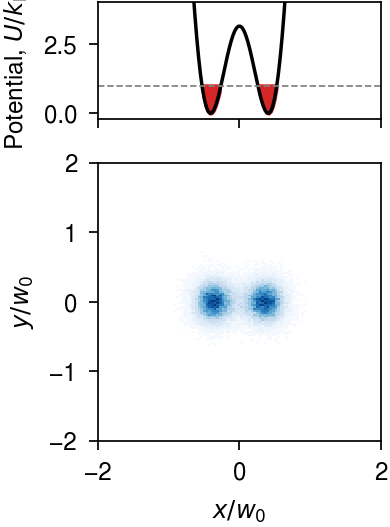

In [253]:
fig, axs = plt.subplot_mosaic(
    """
    A
    B
    B
    """, figsize=(1.75, 2.3),
    sharex=True
)

# Assuming x, y are arrays of measured positions
H, xedges, yedges = np.histogram2d(x, y, bins=50, density=True)
X, Y = np.meshgrid(x, y, indexing='ij')

xlim = 2
xx = np.linspace(-xlim, stop=xlim, num=150)
Umin = np.min(U(x=xx, y=0))
axs['A'].plot(xx, U(x=xx, y=0)-Umin, c='k', lw=1)
axs['A'].axhline(1, lw=0.5, ls='--', color='grey')
selection = (U(x=xx, y=0) < np.min(U(x=xx, y=0)) + np.ones(xx.size)) & (xx<0)

axs['A'].fill_between(xx[selection], (U(x=xx, y=0) - Umin)[selection], np.ones(xx.size)[selection], color='C3')
selection = (U(x=xx, y=0) < np.min(U(x=xx, y=0)) + np.ones(xx.size)) & (xx>0)
axs['A'].fill_between(xx[selection], (U(x=xx, y=0) - Umin)[selection], np.ones(xx.size)[selection], color='C3')

axs['A'].set_ylim(-0.2, 4)
axs['A'].set_xlim(-xlim, xlim)


axs['A'].set_ylabel('Potential, $U/k_{\\text{B}} T$')


axs['B'].pcolormesh(xedges, yedges, H.T, shading='auto', cmap=custom_blues, rasterized=True)


#ticks = [-2, 0, 2]

axs['B'].set_xlabel('$x/w_0$')
axs['B'].set_ylabel('$y/w_0$')

axs['B'].set_ylim(-xlim, xlim)
axs['B'].set_xlim(-xlim, xlim)

#axs['B'].set_ylim(-xlim, xlim)
#axs['B'].set_ylim(-2, 2)
#axs['B'].axis('equal')

#axs['B'].set_xticks(ticks)
#axs['B'].set_yticks(ticks)
plt.savefig(f'results/stochastic3_U0_is_{U0}.pdf')

plt.show()

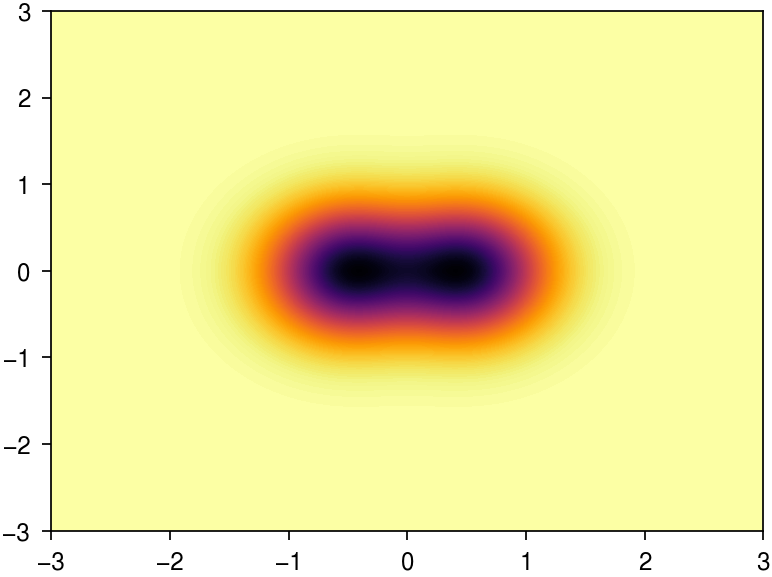

In [218]:
xx = np.linspace(-xlim, stop=xlim, num=150)
yy = np.linspace(-xlim, stop=xlim, num=150)
X, Y = np.meshgrid(xx, yy)
UU = U(x=X, y=Y)
plt.contourf(X, Y, UU, levels=150)
plt.show()

In [84]:
x = 0.2
y = 0.3

external_force(x, y)

(-6.2227501149021425, -8.871770399518697)

In [85]:
dx = 0.01
Fx = - (U(x+dx, y) - U(x-dx, y))/(2*dx)
Fy = - (U(x, y+dx) - U(x, y-dx))/(2*dx)
Fx, Fy

(-6.2227501149021425, -8.871770399518697)

In [62]:
# Parameters
U0 = 5 # [kT]

dt = 0.01                 # Time step
n_steps = 80000           # Number of time steps
dim = 2                   # 2D system


A = 0.5
B = 0
C = 2

r2_max = 3**2
sqrt_2dt = np.sqrt(2 * dt)


def U(x, y):
    return - U0*(A + B * y**2 + C * x**2) * np.exp(-(x**2 + y**2))

# External force function: F(x, y)
def external_force(pos):
    x, y = pos
    rho = np.sqrt(x**2 + y**2)
    
    Fx = - U0*x * (A + B * y**2 + C * (x**2 - 0.5)) * np.exp(-rho**2)
    Fy = - U0*y * (A + C * x**2 + B * (y**2 - 0.5)) * np.exp(-rho**2)
    return np.array([Fx, Fy])

# Initialize position
pos = np.zeros(dim)
trajectory = np.zeros((n_steps, dim))

# Langevin dynamics loop
for i in range(n_steps):
    F = external_force(pos)
    pos += F * dt + sqrt_2dt * np.random.randn(dim)
    if pos[0]**2 + pos[1]**2 > 3**2:
        pos = np.array([0, 0], dtype=float)
    trajectory[i] = pos

x = trajectory[:, 0]
y = trajectory[:, 1]

In [ ]:
fig, axs = plt.subplot_mosaic(
    """
    A
    B
    B
    """, sharex=True, figsize=(3.2, 3)
)

# Assuming x, y are arrays of measured positions
H, xedges, yedges = np.histogram2d(x, y, bins=50, density=True)
X, Y = np.meshgrid(x, y, indexing='ij')

xlim = 3.2
xx = np.linspace(-xlim, stop=xlim, num=150)
Umin = np.min(U(x=xx, y=0))
axs['A'].plot(xx, U(x=xx, y=0)-Umin, c='k', lw=1)
axs['A'].axhline(1, lw=0.5, ls='--', color='grey')
selection = (U(x=xx, y=0) < np.min(U(x=xx, y=0)) + np.ones(xx.size)) & (xx<0)
axs['A'].fill_between(xx[selection], (U(x=xx, y=0) - Umin)[selection], np.ones(xx.size)[selection], color='C3', edgecolor='none')
selection = (U(x=xx, y=0) < np.min(U(x=xx, y=0)) + np.ones(xx.size)) & (xx>0)
axs['A'].fill_between(xx[selection], (U(x=xx, y=0) - Umin)[selection], np.ones(xx.size)[selection], color='C3', edgecolor='none')
axs['A'].set_ylabel('Potential, $U/k_{\\text{B}} T$')



#axs['B'].scatter(trajectory[:, 0], trajectory[:, 1], s=1)
axs['B'].pcolormesh(xedges, yedges, H.T, shading='auto', cmap='Blues')
axs['B'].set_xlabel('x')
axs['B'].set_ylabel('y')
axs['B'].set_ylim(-xlim, xlim)
#axs['B'].set_title('Estimated Probability Density ρ(x, y)')
#plt.colorbar(label='Density')
axs['B'].axis('equal')
axs['B'].set_xlim(-xlim, xlim)

# axs['B'].scatter(trajectory[:, 0], trajectory[:, 1], s=1)
# axs['B'].grid(True)


plt.show()

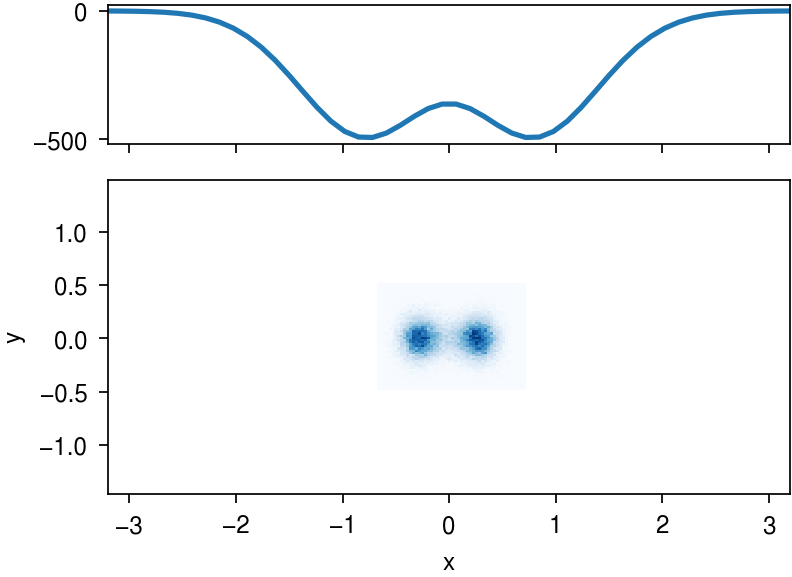

In [3]:
# Parameters
gamma = 2.0               # Friction coefficient
kT = 1                  # Thermal energy (k_B * T)
dt = 0.01                 # Time step
n_steps = 40000           # Number of time steps
dim = 2                   # 2D system

intensity = 180
A = 2
B = 1
C = 5

def U(x, y):
    return - intensity * (A + B * y**2 + C * x**2) * np.exp(-(x**2 + y**2))

# External force function: F(x, y)
def external_force(pos):
    x, y = pos
    rho = np.sqrt(x**2 + y**2)
    
    Fx = -x * (A + B * y**2 + C * (x**2 - 0.5)) * np.exp(-rho**2)
    Fy = -y * (A + C * x**2 + B * (y**2 - 0.5)) * np.exp(-rho**2)
    return intensity * np.array([Fx, Fy])

# Initialize position
pos = np.zeros(dim)
trajectory = np.zeros((n_steps, dim))

# Langevin dynamics loop
for i in range(n_steps):
    F = external_force(pos)
    noise = np.sqrt(2 * kT * dt / gamma) * np.random.randn(dim)
    pos += (F / gamma) * dt + noise
    trajectory[i] = pos

# Plotting
# plt.scatter(trajectory[:, 0], trajectory[:, 1], s=1)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Overdamped Langevin Trajectory in 2D')
# plt.axis('equal')
# plt.grid(True)
# plt.show()

fig, axs = plt.subplot_mosaic(
    """
    A
    B
    B
    """, sharex=True
)

# Assuming x, y are arrays of measured positions
H, xedges, yedges = np.histogram2d(trajectory[:, 0], trajectory[:, 1], bins=50, density=True)
X, Y = np.meshgrid(trajectory[:, 0], trajectory[:, 1], indexing='ij')

xlim = 3.2
xx = np.linspace(-xlim, stop=xlim, num=50)
axs['A'].plot(xx, U(x=xx, y=0))

axs['B'].pcolormesh(xedges, yedges, H.T, shading='auto', cmap='Blues')
axs['B'].set_xlabel('x')
axs['B'].set_ylabel('y')
axs['B'].set_ylim(-xlim, xlim)
#axs['B'].set_title('Estimated Probability Density ρ(x, y)')
#plt.colorbar(label='Density')
axs['B'].axis('equal')
axs['B'].set_xlim(-xlim, xlim)

# axs['B'].scatter(trajectory[:, 0], trajectory[:, 1], s=1)
# axs['B'].grid(True)


plt.show()